In [ ]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge-score py7zr -q


In [ ]:
import torch

if torch.cuda.is_available():
    print("CUDA is available. GPU is accessible.")
else:
    print("CUDA is not available. GPU is not accessible.")


CUDA is available. GPU is accessible.


In [ ]:
from transformers import pipeline

import matplotlib.pyplot as plt
from datasets import load_dataset
import numpy as np
import pandas as pd
from transformers import AutoModelForSeq2SeqLM , AutoTokenizer
import nltk
from nltk.tokenize import sent_tokenize
from tqdm import tqdm
import torch
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
model_for_text="google/flan-t5-small"

In [ ]:
tokenizer=AutoTokenizer.from_pretrained(model_for_text)

In [ ]:
model_T5=AutoModelForSeq2SeqLM.from_pretrained(model_for_text)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
samsum_dataset = load_dataset("samsum")

In [ ]:
samsum_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [ ]:
split_dataset=[len(samsum_dataset[split]) for split in samsum_dataset]
split_dataset

[14732, 819, 818]

In [ ]:
print(f"features samsum_dataset: {samsum_dataset['train'].column_names}")

features samsum_dataset: ['id', 'dialogue', 'summary']


In [ ]:
print(samsum_dataset["train"][3]["dialogue"])

Edward: Rachel, I think I'm in ove with Bella..
rachel: Dont say anything else..
Edward: What do you mean??
rachel: Open your fu**ing door.. I'm outside


In [ ]:
print(samsum_dataset['train'][3]["summary"])

Edward thinks he is in love with Bella. Rachel wants Edward to open his door. Rachel is outside. 


In [ ]:
print(samsum_dataset['test'][3])

{'id': '13729438', 'dialogue': "Will: hey babe, what do you want for dinner tonight?\r\nEmma:  gah, don't even worry about it tonight\r\nWill: what do you mean? everything ok?\r\nEmma: not really, but it's ok, don't worry about cooking though, I'm not hungry\r\nWill: Well what time will you be home?\r\nEmma: soon, hopefully\r\nWill: you sure? Maybe you want me to pick you up?\r\nEmma: no no it's alright. I'll be home soon, i'll tell you when I get home. \r\nWill: Alright, love you. \r\nEmma: love you too. ", 'summary': 'Emma will be home soon and she will let Will know.'}


In [ ]:
dialogue = samsum_dataset['test'][3]['dialogue']

In [ ]:
pipe =pipeline("summarization", model=model_T5, tokenizer=tokenizer)

In [ ]:
#an input will be given to pipe it will generate a summary in output
pipe_out = pipe(dialogue)
pipe_out

Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


[{'summary_text': 'Will is going to pick Emma up. Emma will be home soon. Will will tell Will when he gets home. Emma is not hungry, so Will will pick her up.'}]

In [ ]:
print(pipe_out[0]['summary_text'].replace("<n>", "\n"))

Will is going to pick Emma up. Emma will be home soon. Will will tell Will when he gets home. Emma is not hungry, so Will will pick her up.


In [ ]:
def generate_batchwise_data(dataset, batch_size):
    for i in range(0, len(dataset), batch_size):
        yield dataset[i:i+batch_size]

In [ ]:
def score_calc_using_test_dataset(dataset, metric, model, tokenizer,
                               batch_size=16,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"],
                         attention_mask=inputs["attention_mask"],
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()

    return score

In [ ]:
dataset_samsum = load_dataset("samsum")

split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")

print(dataset_samsum["test"][1]["dialogue"])

print("\nSummary:")

print(dataset_samsum["test"][1]["summary"])


Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)

Summary:
Eric and Rob are going to watch a stand-up on youtube.


In [ ]:
samsum_dataset['test'][3]['dialogue']


"Will: hey babe, what do you want for dinner tonight?\r\nEmma:  gah, don't even worry about it tonight\r\nWill: what do you mean? everything ok?\r\nEmma: not really, but it's ok, don't worry about cooking though, I'm not hungry\r\nWill: Well what time will you be home?\r\nEmma: soon, hopefully\r\nWill: you sure? Maybe you want me to pick you up?\r\nEmma: no no it's alright. I'll be home soon, i'll tell you when I get home. \r\nWill: Alright, love you. \r\nEmma: love you too. "

In [ ]:

pipe = pipeline('summarization', model = model_T5, tokenizer=tokenizer )

pipe_out = pipe(samsum_dataset['test'][3]['dialogue'] )

print(pipe_out)

Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


[{'summary_text': 'Will is going to pick Emma up. Emma will be home soon. Will will tell Will when he gets home. Emma is not hungry, so Will will pick her up.'}]


In [ ]:
print(pipe_out[0]['summary_text'].replace(" .", ".\n"))


Will is going to pick Emma up. Emma will be home soon. Will will tell Will when he gets home. Emma is not hungry, so Will will pick her up.


In [ ]:
from datasets import load_metric

In [ ]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

In [ ]:
rouge_metric = load_metric('rouge')

score = score_calc_using_test_dataset(samsum_dataset['test'], rouge_metric, model_T5, tokenizer, column_text = 'dialogue', column_summary='summary', batch_size=8)

100%|██████████| 103/103 [52:54<00:00, 30.82s/it]


In [ ]:
rouge_types = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_types )

pd.DataFrame(rouge_dict, index = ['flan_t5'])

,rouge1,rouge2,rougeL,rougeLsum
flan_t5,0.020454,0.000312,0.020329,0.020301


Token indices sequence length is longer than the specified maximum sequence length for this model (567 > 512). Running this sequence through the model will result in indexing errors


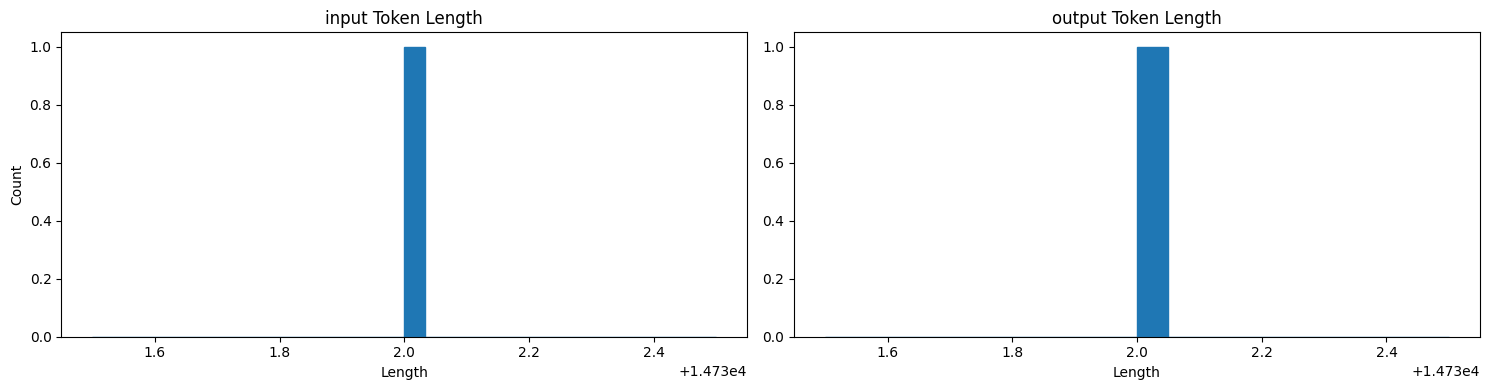

In [ ]:
input_token_len = len([tokenizer.encode(x) for x in samsum_dataset['train']['dialogue']])

output_token_len = len([tokenizer.encode(x) for x in samsum_dataset['train']['summary']])


fig, axes = plt.subplots(1, 2, figsize=(15, 4))
axes[0].hist(input_token_len, bins = 30, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("input Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(output_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("output Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()


In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_T5)

In [ ]:
!pip uninstall -y transformers torch accelerate


Found existing installation: transformers 4.41.2
Uninstalling transformers-4.41.2:
  Successfully uninstalled transformers-4.41.2
Found existing installation: torch 2.3.0+cu121
Uninstalling torch-2.3.0+cu121:
  Successfully uninstalled torch-2.3.0+cu121


In [ ]:
!pip install torch
!pip install transformers[torch]
!pip install accelerate


In [ ]:
pip uninstall -y force


In [ ]:
!pip install  force


  Preparing metadata (setup.py) ... done
  Created wheel for force: filename=force-0.1.4-py3-none-any.whl size=2207 sha256=0535f70f7d7b37d87d224c625dcb20efd2a067a7749781bda12f66bd2935472b
  Stored in directory: /root/.cache/pip/wheels/bc/55/94/c9e7a7796517c494632297f70b7b6adf6d81d9eba51e2a40a1
Successfully built force


In [ ]:
import torch
from transformers import TrainingArguments, Trainer
import accelerate

print(torch.__version__)
print(accelerate.__version__)
print(transformers.__version__)


2.3.0+cu121
0.31.0
4.41.2


In [ ]:
!pip install transformers[torch]

In [ ]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='Flan-t5-samsum-dataset',
    num_train_epochs=1,
    warmup_steps=500,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16
)


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`